# AI 전공 프로젝트
> ### 프로젝트 팀명 : 포토그래퍼(3조)
> ### 프로젝트 주제 : Best Photo Classification and Select Model

## Ⅰ. 개발 환경 설정

> ### 1. 한글폰트 설치

In [ ]:
!apt-get update
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font', family = 'NanumBarunGothic', size=18)

> ### 2. Import Packages

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.models import load_model

import cv2
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import time
## Encoding
# -*- coding: utf-8 -*-

> ### 3. Drive Mount

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ### 4. Load Data

* dataset 목록 확인 

In [ ]:
!ls -l '/content/drive/My Drive/AI_team3/dataset_final/img_final_mdx.zip'

-rw------- 1 root root 311857006 Apr 20 06:29 '/content/drive/My Drive/AI_team3/dataset_final/img_final_mdx.zip'


* Unzip Dataset

In [ ]:
!unzip /content/drive/My\Drive/AI_team3/dataset_final/img_final_mdx.zip

## Ⅱ. Data Preprocessing

> ### 1. Apply Image Generator

* dataset 경로 설정

In [ ]:
image_dir = 'img'

* Image Data Generator 설정 및 적용 (1)

    * train 80% , test 20% 분할

In [ ]:
random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 1515, class_mode = 'binary', subset='training')
test_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=10, class_mode='binary', subset='validation')

Found 1515 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


*  train data - Image set and Label 분리

In [ ]:
X_train, y_train = train.next()

* Image Data Generator 설정 및 적용 (2)
    * train 80% 를 train / validation 으로 분할
    * train 60% / validation 20%

In [ ]:
datagen_second = ImageDataGenerator(validation_split=0.2)

train_generator = datagen_second.flow(X_train, y_train , seed=random_seed, batch_size = 12, subset='training')
valid_generator = datagen_second.flow(X_train, y_train , seed=random_seed, batch_size = 3, subset='validation')

*  train data / validation data 개수 확인

In [ ]:
print(len(train_generator))  ## batch size 12 로 나눈 값 출력
print(len(valid_generator))  ## batch size 3 으로 나눈 값 출력

## train data : 1212
## validation data : 303

101
101


## Ⅲ. Modeling (Transfer Learning)

> ### 1. Transfer Learning Model Load

* Model : VGG16

In [ ]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (640, 640, 3))

> ### 2. Fine Tuning Layer setting

* Tuning Layer : from block5_conv1 ~

In [ ]:
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':       
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

* VGG16 Model Summary

In [ ]:
conv_base.summary()

## Trainable params: 7,079,424

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 640, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 640, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 320, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 320, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 320, 320, 128)     147584    
______________________________________________________________

> ### 3. DNN Layer Define

* 약 55분 소요
* 2 Hidden Layer
* Batch Nomalization and Dropout 적용
* Activation Function : Relu

In [ ]:
tf.keras.initializers.HeNormal()  ## 가중치 초기화 함수 적용

VGG16_model = models.Sequential()
VGG16_model.add(conv_base)   ## VGG16 Model

VGG16_model.add(layers.Flatten())

VGG16_model.add(layers.Dense(512, activation = 'relu'))
VGG16_model.add(layers.Dropout(0.5))
VGG16_model.add(layers.BatchNormalization())

VGG16_model.add(layers.Dense(256))
VGG16_model.add(layers.Dropout(0.2))
VGG16_model.add(layers.BatchNormalization())
VGG16_model.add(layers.Activation('relu'))

VGG16_model.add(layers.Dense(1, activation = 'sigmoid'))   

VGG16_model.summary()

## Total Trainable params: 112,070,657

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 20, 20, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               104858112 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

> ### 4. Model Compile

In [ ]:
VGG16_model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

> ### 5. Model Fitting

In [ ]:
%%time

## 소요 시간 : 55분 

Hist = VGG16_model.fit(train_generator, 
                 steps_per_epoch = train_generator.n // train_generator.batch_size, 
                 epochs = 50, 
                 validation_data = valid_generator,
                 validation_steps=valid_generator.n // valid_generator.batch_size)

Epoch 1/50
101/101 [==============================] - 84s 672ms/step - loss: 0.5428 - accuracy: 0.7211 - val_loss: 0.6434 - val_accuracy: 0.6832
Epoch 2/50
101/101 [==============================] - 64s 631ms/step - loss: 0.3664 - accuracy: 0.8424 - val_loss: 0.3126 - val_accuracy: 0.8746
Epoch 3/50
101/101 [==============================] - 64s 639ms/step - loss: 0.2801 - accuracy: 0.9026 - val_loss: 0.2889 - val_accuracy: 0.8845
Epoch 4/50
101/101 [==============================] - 65s 645ms/step - loss: 0.2537 - accuracy: 0.9059 - val_loss: 0.2742 - val_accuracy: 0.8779
Epoch 5/50
101/101 [==============================] - 65s 647ms/step - loss: 0.1893 - accuracy: 0.9563 - val_loss: 0.2706 - val_accuracy: 0.8977
Epoch 6/50
101/101 [==============================] - 66s 650ms/step - loss: 0.1979 - accuracy: 0.9373 - val_loss: 0.3505 - val_accuracy: 0.8614
Epoch 7/50
101/101 [==============================] - 66s 652ms/step - loss: 0.1771 - accuracy: 0.9513 - val_loss: 0.2631 - val_ac

## Ⅳ. Model 평가

* test data 활용
* Accuracy : 0.92838
* Loss : 0.17416

In [ ]:
loss, accuracy = VGG16_model.evaluate(test_generator)
print(f'Loss : {loss:.5f}')
print(f'Accuracy : {accuracy:.5f}')

38/38 [==============================] - 39s 709ms/step - loss: 0.1742 - accuracy: 0.9284
Loss : 0.17416
Accuracy : 0.92838


* Loss and Accuracy Visualization

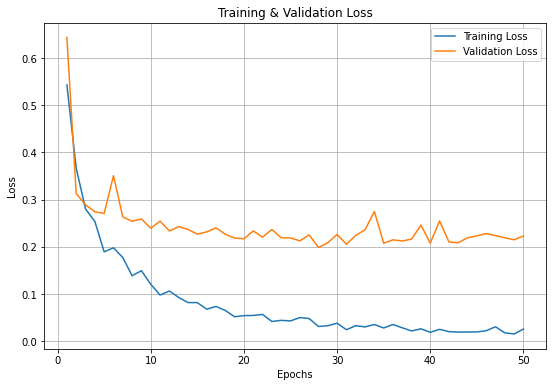

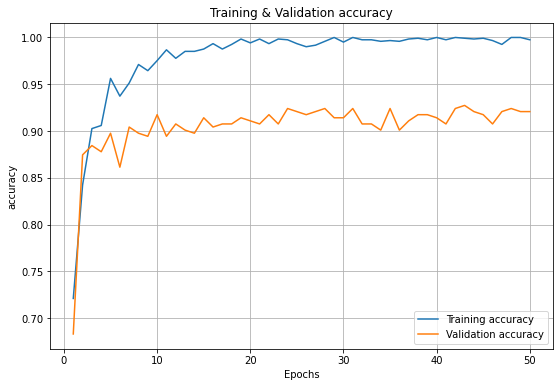

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()
print()

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])

plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

## Ⅴ. best / worst 분류 시각화

In [31]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/*/')[0])
print(data_root)
# label = ['0','1']

/content/img


* .jpg 파일 목록 저장

In [ ]:
import random

all_image_paths = list(data_root.glob('*/*/'))
all_image_paths = [str(path) for path in all_image_paths]

# random.choice(all_image_paths)
all_image_paths

In [39]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

plt.figure(figsize=((16, 25)))


for n in range(15):
    #랜덤 이미지 경로 추출
    image_path = random.choice(all_image_paths)
    
    #이미지 크기 변경 
    img = cv2.imread(image_path)
    img = cv2.resize(img, (640,640))

    # 이미지 크기 정규화
    reg = img / 255.0  
    reg = np.expand_dims(reg, axis=0)

    # 이미지 분류
    logits = VGG16_model.predict(reg)[0]

    #이미지 출력
    plt.subplot(5,3, n+1)
    plt.imshow(plt.imread(image_path))
    idx = image_path.split('/')[-2]
    plt.title('label: ' + str(idx))
    plt.xlabel('Prediction : ' + str(logits))

Output hidden; open in https://colab.research.google.com to view.

## Ⅵ. Model Save

* 저장 경로 설정

In [ ]:
VGG16_model.save('/content/drive/My Drive/Colab Notebooks/models/VGG16_5-1_addBatchNormal&test_split_0.928.h5')  # train time : 55분

* 저장 결과 확인

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 5263305
-rw------- 1 root root 2638611656 Apr 19 04:44  baseModel_ResNet.h5
-rw------- 1 root root 1375505480 Apr 21 02:17  VGG16_5-1_addBatchNormal_0.904.h5
-rw------- 1 root root 1375505480 Apr 21 05:28 'VGG16_5-1_addBatchNormal&test_split_0.928.h5'


## Ⅶ. Model 불러오기

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from keras.models import load_model
VGG16_model = load_model('/content/drive/My Drive/Colab Notebooks/models/VGG16_5-1_addBatchNormal&test_split_0.928.h5')

## Ⅷ. Best Photo Select Model

> ### 1. Data Load

* dataset 목록 확인 

In [5]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'

-rw------- 1 root root 311857006 Apr 20 06:29 '/content/drive/My Drive/AI_team3/dataset_final/img_final_mdx.zip'


* Unzip Dataset

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'

> ### 2. Input Data Path 설정

In [8]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/*/')[0])
print(data_root)
# label = ['0','1']

/content/img


* .jpg 파일 목록 저장

In [9]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# random.choice(all_image_paths)
# all_image_paths

> ### 4. Image Selector 실행

* Input : 
    * 사진 10장
    * Best / Worst 사진 분류 Model (VGG16)

* 사진 10장 분류 확률

In [10]:
plt.figure(figsize=(20,40))

for idx in range(10):
    #랜덤 이미지 경로 추출
    image_path = random.choice(all_image_paths)
    
    #이미지 크기 변경 
    img = cv2.imread(image_path)
    img = cv2.resize(img, (640,640))

    # 이미지 크기 정규화
    reg = img / 255.0  
    reg = np.expand_dims(reg, axis=0)

    # 이미지 분류
    logits = VGG16_model.predict(reg)[0]
    logit = float(logits[0] ) * 100

    #이미지 출력
    ax = plt.subplot(5, 2,idx+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(plt.imread(image_path))

    if logit <= 50:
      plt.title('당신은 이 시대의 진정한 똥손')
    else:
      plt.title(f"좋아요를 받을 확률:  {logit:.1f}%")

Output hidden; open in https://colab.research.google.com to view.

# 부록 : 프로젝트 시연을 위한 토너먼트

* 팀원 4명 중 베스트 사진 뽑기 <br>
    1) 베스트 2장 추출 <br>
    2) 최고점 베스트 사진 1장 추출

In [24]:
########### 팀원들 사진 파일 url ########

data_root = pathlib.Path(glob('/content/drive/MyDrive/AI_team3/dataset_final/*')[7])
# print(data_root)
all_image_paths = list(data_root.glob('*'))
team_img_path = [str(path) for path in all_image_paths]

img_dict = {}
value = []

/content/drive/MyDrive/AI_team3/dataset_final/BestPhoto


In [25]:
team_img_path

['/content/drive/MyDrive/AI_team3/dataset_final/BestPhoto/전승우.jpg',
 '/content/drive/MyDrive/AI_team3/dataset_final/BestPhoto/IMG_BOMI.jpg',
 '/content/drive/MyDrive/AI_team3/dataset_final/BestPhoto/F1B94735-1659-4D46-B28A-1914D3B006DB_1_201_a.jpeg',
 '/content/drive/MyDrive/AI_team3/dataset_final/BestPhoto/KakaoTalk_20210423_150602461.jpg']

* Define Image Selector function

In [26]:
def image_select_TOP2(path, model) :
    global img_dict, value

    for idx, image in enumerate(path) :
        img = cv2.imread(image)
        img = cv2.resize(img, (640,640))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        logits = model.predict(img)[0]
        # logit = float(logits[0]) * 100
        img_dict[image] = logits

        value.append(logits[0])

    value.sort(reverse=True)

    for k, v in img_dict.items() :
        if v == value[0] :
            top1 = k
        elif v == value[1] :
            top2 = k

    print("3조의 TOP2는 두구두구")
    
    time.sleep(3)

    plt.figure(figsize=(8,8))
    plt.subplot()
    plt.axis('off')
    plt.imshow(plt.imread(top1))
    plt.title('후보 1번!')
    plt.show()

    time.sleep(3)

    plt.figure(figsize=(8,8))
    plt.subplot()
    plt.axis('off')
    plt.imshow(plt.imread(top2))
    plt.title('후보 2번!')
    plt.show()

    return top1, top2

In [27]:
def image_select_Top(img1, img2) : 
    for k, v in img_dict.items() : 
        if v == value[0] : 
            plt.figure(figsize=(10,10))
            plt.subplot()
            plt.axis('off')
            plt.imshow(plt.imread(k))
            v = float(v) * 100
            plt.title(f'프로작가이시네요! : {v:.2f}%')
            plt.show()

    return 

  1) Best 확률값 상위 2개 후보 사진 select

3조의 TOP2는 두구두구


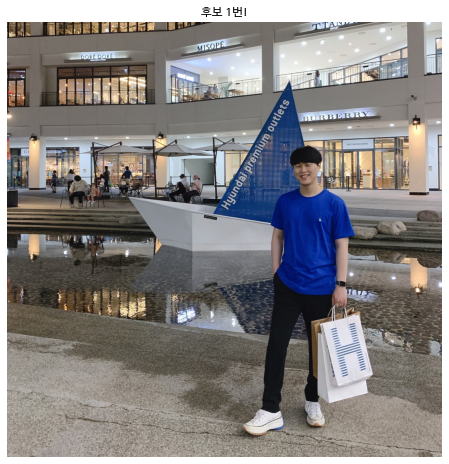

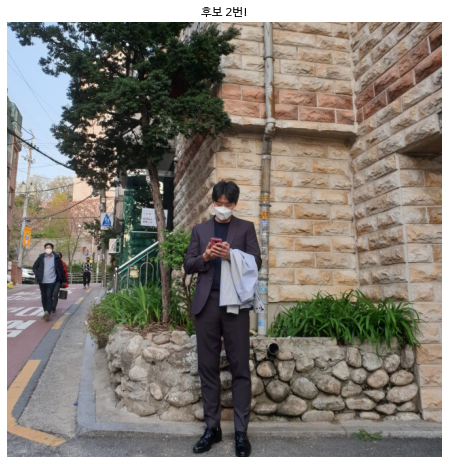

In [28]:
img1, img2 = image_select_TOP2(team_img_path, VGG16_model)

  2) Best 최고값 select

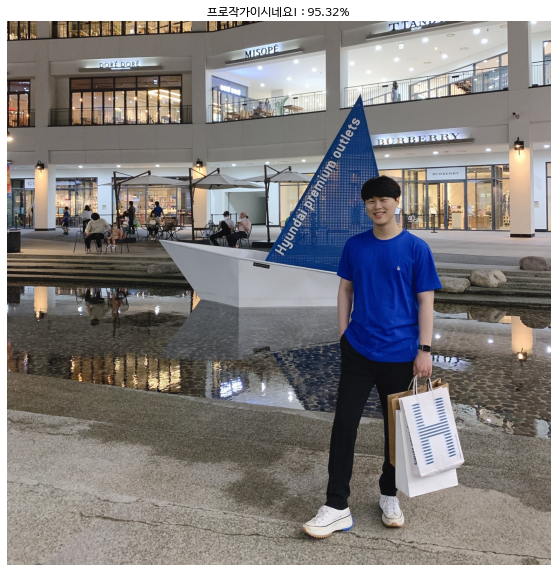

In [29]:
image_select_Top(img1, img2)